In [ ]:
!pip install keras-tuner


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LeakyReLU


from matplotlib.backends.backend_pdf import PdfPages
from google.colab import files
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Activation, Dropout, LeakyReLU
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

# Functions

In [ ]:
def create_dataset(dataset, look_back=1, response_variable_index=0, multi_feature = True):
  dataX, dataY = [], []
  if multi_feature :
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back)]
      dataX.append(a)
      dataY.append(dataset[i + look_back, response_variable_index])
  else:
    for i in range(len(dataset)-look_back-1):
      a = dataset[i:(i+look_back-1),response_variable_index]
      dataX.append(a)
      dataY.append(dataset[i + look_back, response_variable_index])
  return np.array(dataX), np.array(dataY)

In [ ]:
def prepare(df, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8):
  df = df.astype("float32")
  scaler = MinMaxScaler(feature_range=scaling_range)
  dataset = scaler.fit_transform(df)
  X, Y = create_dataset(dataset, time_step, response_variable_index, multi_feature = True)
  # split into train and test sets
  train_size = int(len(dataset) * data_split_ratio)
  test_size = len(dataset) - train_size
  trainX, testX = X[0:train_size,:], X[train_size:len(dataset),:]
  trainY, testY = Y[0:train_size], Y[train_size:len(dataset)]
  #print(trainX.shape)
  #print(testX.shape)
  # reshape input to be [samples, time steps, features]
  if not multi_feature:
    trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))
    #print(trainX.shape)
  X_train=trainX
  X_test=testX
  y_train=trainY.reshape(-1,1)
  y_test=testY.reshape(-1,1)
  return X_train,X_test, y_train, y_test

In [ ]:
def model_cnn():
  model_cnn = keras.Sequential()
  model_cnn.add(Conv1D(filters=16,
        kernel_size=3,
        input_shape=(X_train.shape[1], X_train.shape[2])
            )
                  )
  model_cnn.add(LeakyReLU(alpha=0.1))
  model_cnn.add(MaxPooling1D(pool_size=1))
  model_cnn.add(Dropout(rate=0.2))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(1))
  model_cnn.compile(loss='mae', optimizer='adam')
  return model_cnn


In [ ]:
def fit(model, X_train, X_test, y_train, y_test):
  history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor= "val_loss", patience=10)], shuffle=False)
  return history


In [ ]:
def predict(model, y_test):
  y_test_pre = model.predict(X_test)
  return y_test_pre

In [ ]:
def visualize(y_test, y_pre, title):
  results = pd.DataFrame()
  #results['Date']= date_test.reset_index().Date.iloc[1:-1]
  #results["Date"] = date_test
  results["predicted"]=[i[0] for i in y_pre][1:] 
  results["true"] = y_test[:-1]
  #results = results.set_index(["Date"])
  #results.head()
  pyplot.plot(results["predicted"], label='predicted', color='red')
  pyplot.plot(results["true"], label='true', color= 'green')
  pyplot.legend()
  pyplot.title(title)
  pyplot.show()

In [ ]:
def evaluate(y_test, y_pre):
  true = y_test[:-1]
  predicted = [i[0] for i in y_pre][1:]
  rmse = np.sqrt(mean_squared_error(true, predicted))
  mae = mean_absolute_error(true, predicted)
  #print(len(true))
  #print(len(predicted))
  return rmse, mae


# Keras Tuner

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv1D(
        hp.Int("input_units", min_value=16, max_value=256, step=16),
        kernel_size= hp.Choice('conv_1_kernel', values = [1,5]),
        input_shape= (X_train.shape[1], X_train.shape[2])
    ),
    keras.layers.LeakyReLU(alpha=0.1),
    keras.layers.MaxPooling1D(1),
   
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2)
    
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='mae',
              metrics=['mae'])
  print(model.summary())
  return model

In [ ]:
log_dir = "logs"


#Import Data

In [ ]:
# Maharashtra
df_Ma = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Maharashtra.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Karnataka
df_Ka = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Karnataka.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Kerala
df_Ke = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Kerala.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Tamil Nadu
df_TN = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Tamil-Nadu.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])
# Uttar Pradesh
df_UP = pd.read_csv("https://raw.githubusercontent.com/sureshkuc/Data-Science-in-Life-Science-Project/main/Indian-States-Covid19-Datasets/Uttar-Pradesh.csv", parse_dates=["Date"]).drop(columns =["Unnamed: 0"])



In [ ]:
df_Ma = df_Ma[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_Ka = df_Ka[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_Ke = df_Ke[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_TN = df_TN[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]
df_UP = df_UP[["Date", "Confirmed", "Recovered", "Deceased", "New_Confirmerd", "New_Deaths", "New_Recovered"]]

In [ ]:
df_Ma = df_Ma[df_Ma["Date"] > "2020-03-09"]
df_Ka = df_Ka[df_Ka["Date"] > "2020-03-09"]
df_Ke = df_Ke[df_Ke["Date"] > "2020-03-09"]
df_TN = df_TN[df_TN["Date"] > "2020-03-09"]
df_UP = df_UP[df_UP["Date"] > "2020-03-09"]

In [ ]:
df_Ma = df_Ma.set_index("Date")
df_Ka = df_Ka.set_index("Date")
df_Ke = df_Ke.set_index("Date")
df_TN = df_TN.set_index("Date")
df_UP = df_UP.set_index("Date")


In [ ]:
RMSE_cnn = []
MAE_cnn = []
RMSE_tun = []
MAE_tun = []
states = ["Maharashtra", "Karnataka", "Kerala", "Tamil Nadu", "Uttar Pradesh"]

# Maharashtra

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ma, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (364, 5, 6)
X_test.shape (86, 5, 6)
y_train.shape (364, 1)
y_test.shape (86, 1)


In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0679 - val_loss: 0.1217
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0596
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0609
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0955
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0726
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.1265
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.1267
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0705
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0355 - val_loss: 0.0630
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0909
Epoch 11/

In [ ]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3, 16)             304       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3, 16)             0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 16)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 16)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 49        
Total params: 353
Trainable params: 353
Non-trainable params: 0
________________________________________________________

CNN RESULTS
RMSE =  0.08641861
MAE =  0.076487124


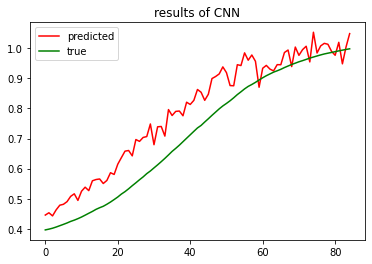

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")


In [ ]:
tuner =  RandomSearch( build_model, objective= "mae", max_trials=2, executions_per_trial= 2, directory= "log_dir", overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             112       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 16)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tuner.search(X_train, y_train, epochs= 100, batch_size= 16, validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 18s]
mae: 0.0356050468981266

Best mae So Far: 0.0356050468981266
Total elapsed time: 00h 00m 33s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in log_dir/untitled_project
Showing 10 best trials
Objective(name='mae', direction='min')
Trial summary
Hyperparameters:
input_units: 144
conv_1_kernel: 5
learning_rate: 0.001
Score: 0.0356050468981266
Trial summary
Hyperparameters:
input_units: 80
conv_1_kernel: 5
learning_rate: 0.01
Score: 0.03958258591592312


In [ ]:
model_cnn_tuner = keras.Sequential()
model_cnn_tuner.add(Conv1D(filters=144,
  kernel_size=5,
  input_shape=(X_train.shape[1], X_train.shape[2])
              )
                    )
model_cnn_tuner.add(LeakyReLU(alpha=0.1))
model_cnn_tuner.add(MaxPooling1D(pool_size=1))
model_cnn_tuner.add(Dropout(rate=0.2))
model_cnn_tuner.add(Flatten())
model_cnn_tuner.add(Dense(1))
model_cnn_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mae",
              metrics=["mae"])

In [ ]:
fit(model_cnn_tuner, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.1496 - val_mae: 0.1496
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0756 - mae: 0.0756 - val_loss: 0.1577 - val_mae: 0.1577
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0765 - mae: 0.0765 - val_loss: 0.5895 - val_mae: 0.5895
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1256 - mae: 0.1256 - val_loss: 0.0826 - val_mae: 0.0826
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0815 - val_mae: 0.0815
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0829 - val_mae: 0.0829
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0171 - m

CNN_tun RESULTS
RMSE =  0.0869774
MAE =  0.08031924


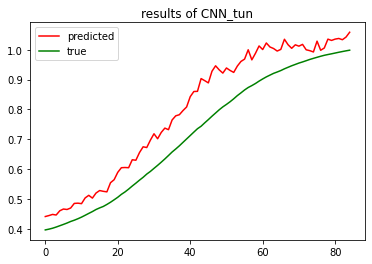

In [ ]:
y_test_pre_cnn_t = predict(model_cnn_tuner, y_test)
print("CNN_tun RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn_t)
RMSE_tun.append(rmse)
MAE_tun.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn_t, "results of CNN_tun")

# Karnataka


In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ka, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.1398 - val_loss: 0.3473
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0887
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0577
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0560
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0361 - val_loss: 0.0613
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0833
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0855
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0240 - val_loss: 0.0716
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0246 - val_loss: 0.1346
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0744
Epoch 11/

CNN RESULTS
RMSE =  0.15430492
MAE =  0.10560146


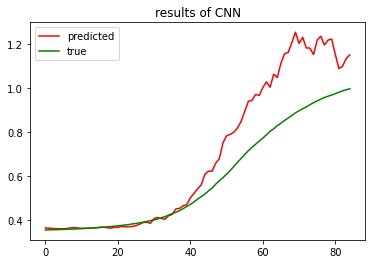

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")


In [ ]:
log_dir = "logs"
tuner =  RandomSearch( build_model, objective= "mae", max_trials=2, executions_per_trial= 2, directory= "log_dir", overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             112       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 16)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tuner.search(X_train, y_train, epochs=100, batch_size= 16, validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 18s]
mae: 0.03796365484595299

Best mae So Far: 0.03385276161134243
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in log_dir/untitled_project
Showing 10 best trials
Objective(name='mae', direction='min')
Trial summary
Hyperparameters:
input_units: 96
conv_1_kernel: 5
learning_rate: 0.001
Score: 0.03385276161134243
Trial summary
Hyperparameters:
input_units: 144
conv_1_kernel: 5
learning_rate: 0.01
Score: 0.03796365484595299


In [ ]:
model_cnn_tuner = keras.Sequential()
model_cnn_tuner.add(Conv1D(filters=96,
  kernel_size=5,
  input_shape=(X_train.shape[1], X_train.shape[2])
              )
                    )
model_cnn_tuner.add(LeakyReLU(alpha=0.1))
model_cnn_tuner.add(MaxPooling1D(pool_size=1))
model_cnn_tuner.add(Dropout(rate=0.2))
model_cnn_tuner.add(Flatten())
model_cnn_tuner.add(Dense(1))
model_cnn_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mae",
              metrics=["mae"])

In [ ]:
fit(model_cnn_tuner, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0433 - mae: 0.0433 - val_loss: 0.3719 - val_mae: 0.3719
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0770 - mae: 0.0770 - val_loss: 0.0611 - val_mae: 0.0611
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0234 - mae: 0.0234 - val_loss: 0.1386 - val_mae: 0.1386
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0562 - val_mae: 0.0562
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0297 - mae: 0.0297 - val_loss: 0.1255 - val_mae: 0.1255
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0755 - val_mae: 0.0755
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0798 - val_mae: 0.0798
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0269 - m

CNN_tun RESULTS
RMSE =  0.081083015
MAE =  0.06909799


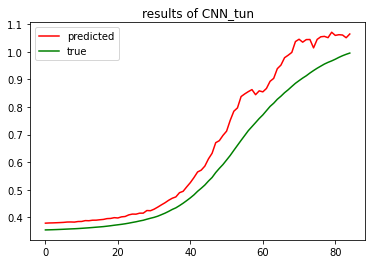

In [ ]:
y_test_pre_cnn_t = predict(model_cnn_tuner, y_test)
print("CNN_tun RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn_t)
RMSE_tun.append(rmse)
MAE_tun.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn_t, "results of CNN_tun")

# Kerala

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_Ke, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.0586 - val_loss: 0.0925
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0673 - val_loss: 0.0818
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0813
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0628
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0769
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0582
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0652
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0280 - val_loss: 0.0830
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0253 - val_loss: 0.0567
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0208 - val_loss: 0.0562
Epoch 11/

CNN RESULTS
RMSE =  0.13467601
MAE =  0.10137611


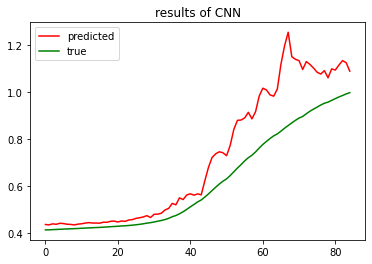

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")


In [ ]:
tuner =  RandomSearch( build_model, objective= "mae", max_trials=2, executions_per_trial= 2, directory= "log_dir", overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             112       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 16)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tuner.search(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 18s]
mae: 0.025344809517264366

Best mae So Far: 0.025344809517264366
Total elapsed time: 00h 00m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in log_dir/untitled_project
Showing 10 best trials
Objective(name='mae', direction='min')
Trial summary
Hyperparameters:
input_units: 192
conv_1_kernel: 5
learning_rate: 0.001
Score: 0.025344809517264366
Trial summary
Hyperparameters:
input_units: 16
conv_1_kernel: 1
learning_rate: 0.01
Score: 0.02586822584271431


In [ ]:
model_cnn_tuner = keras.Sequential()
model_cnn_tuner.add(Conv1D(filters=192,
  kernel_size=5,
  input_shape=(X_train.shape[1], X_train.shape[2])
              )
                    )
model_cnn_tuner.add(LeakyReLU(alpha=0.1))
model_cnn_tuner.add(MaxPooling1D(pool_size=1))
model_cnn_tuner.add(Dropout(rate=0.2))
model_cnn_tuner.add(Flatten())
model_cnn_tuner.add(Dense(1))
model_cnn_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mae",
              metrics=["mae"])

In [ ]:
fit(model_cnn_tuner, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 1s 7ms/step - loss: 0.0117 - mae: 0.0117 - val_loss: 0.1943 - val_mae: 0.1943
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0534 - mae: 0.0534 - val_loss: 0.0340 - val_mae: 0.0340
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0209 - mae: 0.0209 - val_loss: 0.1266 - val_mae: 0.1266
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0745 - val_mae: 0.0745
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0140 - mae: 0.0140 - val_loss: 0.0552 - val_mae: 0.0552
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0233 - mae: 0.0233 - val_loss: 0.0240 - val_mae: 0.0240
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0356 - mae: 0.0356 - val_loss: 0.1023 - val_mae: 0.1023
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0772 - m

CNN_tun RESULTS
RMSE =  0.05059366
MAE =  0.044362705


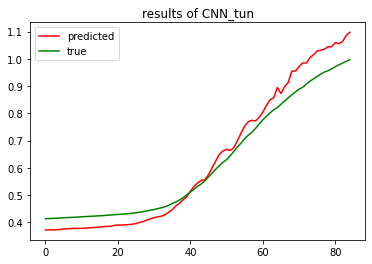

In [ ]:
y_test_pre_cnn_t = predict(model_cnn_tuner, y_test)
print("CNN_tun RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn_t)
RMSE_tun.append(rmse)
MAE_tun.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn_t, "results of CNN_tun")

# Tamil Nadu



In [ ]:
X_train,X_test, y_train, y_test = prepare(df_TN, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.1022 - val_loss: 0.2567
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.2268
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.1563
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.2111
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.1549
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.1786
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.2196
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0706
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.1940
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.1271
Epoch 11/

CNN RESULTS
RMSE =  0.14178877
MAE =  0.1084182


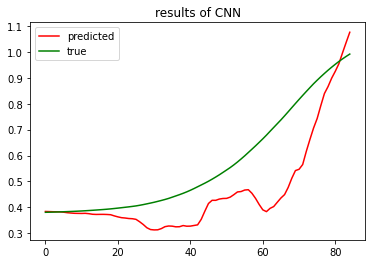

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")


In [ ]:
tuner =  RandomSearch( build_model, objective= "mae", max_trials=2, executions_per_trial= 2, directory= "log_dir", overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             112       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 16)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tuner.search(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 16s]
mae: 0.040923647582530975

Best mae So Far: 0.03913860209286213
Total elapsed time: 00h 00m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in log_dir/untitled_project
Showing 10 best trials
Objective(name='mae', direction='min')
Trial summary
Hyperparameters:
input_units: 32
conv_1_kernel: 5
learning_rate: 0.001
Score: 0.03913860209286213
Trial summary
Hyperparameters:
input_units: 128
conv_1_kernel: 1
learning_rate: 0.01
Score: 0.040923647582530975


In [ ]:
model_cnn_tuner = keras.Sequential()
model_cnn_tuner.add(Conv1D(filters=32,
  kernel_size=5,
  input_shape=(X_train.shape[1], X_train.shape[2])
              )
                    )
model_cnn_tuner.add(LeakyReLU(alpha=0.1))
model_cnn_tuner.add(MaxPooling1D(pool_size=1))
model_cnn_tuner.add(Dropout(rate=0.2))
model_cnn_tuner.add(Flatten())
model_cnn_tuner.add(Dense(1))
model_cnn_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mae",
              metrics=["mae"])

In [ ]:
fit(model_cnn_tuner, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0918 - mae: 0.0918 - val_loss: 0.0183 - val_mae: 0.0183
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.0743 - val_loss: 0.1192 - val_mae: 0.1192
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0522 - mae: 0.0522 - val_loss: 0.0090 - val_mae: 0.0090
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0448 - mae: 0.0448 - val_loss: 0.1429 - val_mae: 0.1429
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0402 - mae: 0.0402 - val_loss: 0.0153 - val_mae: 0.0153
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0429 - mae: 0.0429 - val_loss: 0.1070 - val_mae: 0.1070
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0313 - mae: 0.0313 - val_loss: 0.0533 - val_mae: 0.0533
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0281 - m

CNN_tun RESULTS
RMSE =  0.017732266
MAE =  0.015831325


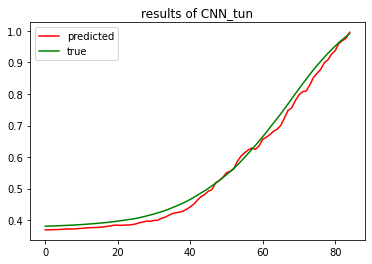

In [ ]:
y_test_pre_cnn_t = predict(model_cnn_tuner, y_test)
print("CNN_tun RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn_t)
RMSE_tun.append(rmse)
MAE_tun.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn_t, "results of CNN_tun")

# Uttar Pradesh

In [ ]:
X_train,X_test, y_train, y_test = prepare(df_UP, scaling_range=(0,1),time_step=5,multi_feature=True, response_variable_index=0,data_split_ratio=0.8)

In [ ]:
model_CNN = model_cnn()
fit(model_CNN, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.1827 - val_loss: 0.3935
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.1159 - val_loss: 0.1680
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0706 - val_loss: 0.0928
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0598
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0980
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.1307
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0714
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0657
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0687
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0396
Epoch 11/

CNN RESULTS
RMSE =  0.07383372
MAE =  0.055243347


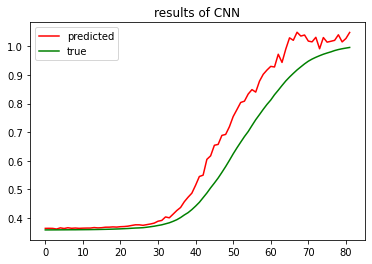

In [ ]:
y_test_pre_cnn = predict(model_CNN, y_test)
print("CNN RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn)
RMSE_cnn.append(rmse)
MAE_cnn.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn, "results of CNN")


In [ ]:
tuner =  RandomSearch( build_model, objective= "mae", max_trials=2, executions_per_trial= 2, directory= "log_dir", overwrite=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 16)             112       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 5, 16)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 80)                0         
_________________________________________________________________
dropout (Dropout)            (None, 80)                0         
Total params: 112
Trainable params: 112
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tuner.search(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test))

Trial 2 Complete [00h 00m 18s]
mae: 0.03499121591448784

Best mae So Far: 0.033767541870474815
Total elapsed time: 00h 00m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in log_dir/untitled_project
Showing 10 best trials
Objective(name='mae', direction='min')
Trial summary
Hyperparameters:
input_units: 112
conv_1_kernel: 5
learning_rate: 0.001
Score: 0.033767541870474815
Trial summary
Hyperparameters:
input_units: 80
conv_1_kernel: 1
learning_rate: 0.01
Score: 0.03499121591448784


In [ ]:
model_cnn_tuner = keras.Sequential()
model_cnn_tuner.add(Conv1D(filters=112,
  kernel_size=5,
  input_shape=(X_train.shape[1], X_train.shape[2])
              )
                    )
model_cnn_tuner.add(LeakyReLU(alpha=0.1))
model_cnn_tuner.add(MaxPooling1D(pool_size=1))
model_cnn_tuner.add(Dropout(rate=0.2))
model_cnn_tuner.add(Flatten())
model_cnn_tuner.add(Dense(1))
model_cnn_tuner.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss="mae",
              metrics=["mae"])

In [ ]:
fit(model_cnn_tuner, X_train, X_test, y_train, y_test)

Epoch 1/100
23/23 [==============================] - 0s 7ms/step - loss: 0.0193 - mae: 0.0193 - val_loss: 0.1551 - val_mae: 0.1551
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0429 - mae: 0.0429 - val_loss: 0.0704 - val_mae: 0.0704
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0531 - val_mae: 0.0531
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0254 - mae: 0.0254 - val_loss: 0.0372 - val_mae: 0.0372
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.1425 - val_mae: 0.1425
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0502 - mae: 0.0502 - val_loss: 0.1824 - val_mae: 0.1824
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0562 - mae: 0.0562 - val_loss: 0.1863 - val_mae: 0.1863
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0640 - m

CNN_tun RESULTS
RMSE =  0.09005914
MAE =  0.06727739


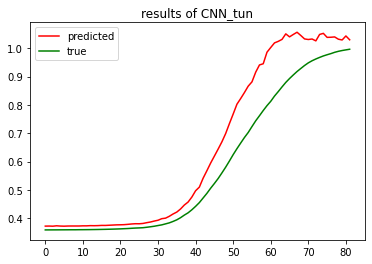

In [ ]:
y_test_pre_cnn_t = predict(model_cnn_tuner, y_test)
print("CNN_tun RESULTS")
rmse, mae = evaluate(y_test, y_test_pre_cnn_t)
RMSE_tun.append(rmse)
MAE_tun.append(mae)
print("RMSE = ", rmse)
print("MAE = ", mae)

visualize(y_test, y_test_pre_cnn_t, "results of CNN_tun")

# Comparison

In [ ]:
compare = pd.DataFrame()
compare["State"] = states
compare["rmse_cnn"] = RMSE_cnn
compare["rmse_cnn_t"] = RMSE_tun
compare["mae_cnn"] = MAE_cnn
compare["mae_cnn_t"] = MAE_tun
compare = compare.round(4)

In [ ]:
MAE_cnn = [0.0765, 0.1056, 0.1014, 0.1084, 0.0552]
RMSE_cnn = [0.0864, 0.1543, 0.1347, 0.1418, 0.0738]

NameError: ignored

In [ ]:
compare.head()

,State,rmse_cnn,rmse_cnn_t,mae_cnn,mae_cnn_t
0,Maharashtra,0.0864,0.0870,0.0765,0.0803
1,Karnataka,0.1543,0.0811,0.1056,0.0691
2,Kerala,0.1347,0.0506,0.1014,0.0444
3,Tamil Nadu,0.1418,0.0177,0.1084,0.0158
4,Uttar Pradesh,0.0738,0.0901,0.0552,0.0673


In [ ]:
compare.mean(axis=0)

rmse_cnn      0.11820
rmse_cnn_t    0.06530
mae_cnn       0.08942
mae_cnn_t     0.05538
dtype: float64

In [ ]:
compare.to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n{} &          State &  rmse\\_cnn &  rmse\\_cnn\\_t &  mae\\_cnn &  mae\\_cnn\\_t \\\\\n\\midrule\n0 &    Maharashtra &    0.0864 &      0.0870 &   0.0765 &     0.0803 \\\\\n1 &      Karnataka &    0.1543 &      0.0811 &   0.1056 &     0.0691 \\\\\n2 &         Kerala &    0.1347 &      0.0506 &   0.1014 &     0.0444 \\\\\n3 &     Tamil Nadu &    0.1418 &      0.0177 &   0.1084 &     0.0158 \\\\\n4 &  Uttar Pradesh &    0.0738 &      0.0901 &   0.0552 &     0.0673 \\\\\n\\bottomrule\n\\end{tabular}\n'